In [ ]:
import numpy as np
if not hasattr(np, 'bool8'):
    np.bool8 = np.bool_


Training with Base uncertainty:
Episode 0, Reward: 16.00
Episode 1, Reward: 11.00
Episode 2, Reward: 16.00
Episode 3, Reward: 18.00


/usr/local/lib/python3.11/dist-packages/gym/core.py:317: DeprecationWarning:

WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.



Streaming output truncated to the last 5000 lines.
Episode 8, Reward: 25.00
Episode 9, Reward: 24.00
Episode 10, Reward: 17.00
Episode 11, Reward: 27.00
Episode 12, Reward: 25.00
Episode 13, Reward: 30.00
Episode 14, Reward: 18.00
Episode 15, Reward: 13.00
Episode 16, Reward: 22.00
Episode 17, Reward: 10.00
Episode 18, Reward: 22.00
Episode 19, Reward: 15.00
Episode 20, Reward: 17.00
Episode 21, Reward: 15.00
Episode 22, Reward: 14.00
Episode 23, Reward: 14.00
Episode 24, Reward: 16.00
Episode 25, Reward: 14.00
Episode 26, Reward: 12.00
Episode 27, Reward: 15.00
Episode 28, Reward: 12.00
Episode 29, Reward: 37.00
Episode 30, Reward: 14.00
Episode 31, Reward: 14.00
Episode 32, Reward: 11.00
Episode 33, Reward: 14.00
Episode 34, Reward: 20.00
Episode 35, Reward: 36.00
Episode 36, Reward: 15.00
Episode 37, Reward: 11.00
Episode 38, Reward: 14.00
Episode 39, Reward: 18.00
Episode 40, Reward: 13.00
Episode 41, Reward: 19.00
Episode 42, Reward: 10.00
Episode 43, Reward: 12.00
Episode 44, Rew

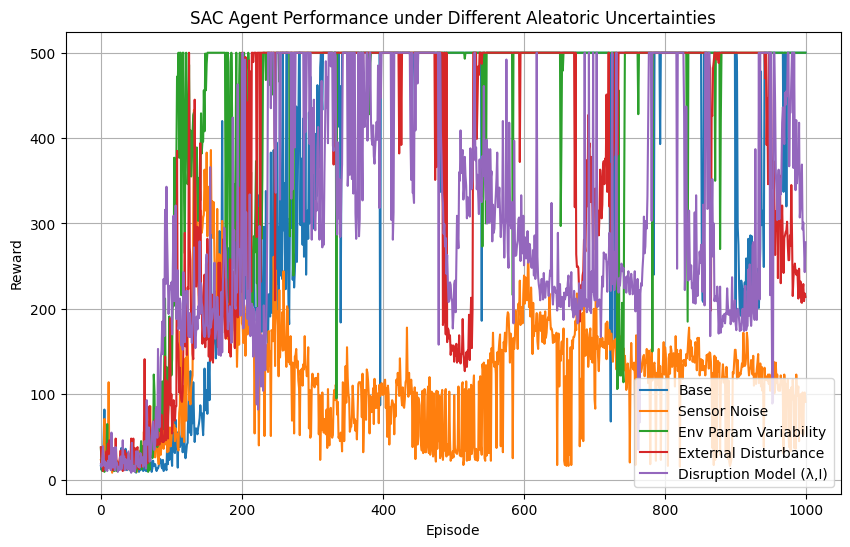

In [ ]:
import gym
import random
#import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Normal
from collections import deque
import matplotlib.pyplot as plt

# ------------------------------
# 1. Define the SAC components
# ------------------------------

class Actor(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=24, log_std_min=-20, log_std_max=2):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(state_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)

        # Mean and log_std outputs
        self.mean = nn.Linear(hidden_dim, action_dim)
        self.log_std = nn.Linear(hidden_dim, action_dim)

        self.log_std_min = log_std_min
        self.log_std_max = log_std_max

        self.action_dim = action_dim

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))

        mean = self.mean(x)
        log_std = self.log_std(x)
        log_std = torch.clamp(log_std, self.log_std_min, self.log_std_max)

        return mean, log_std

    def sample(self, state):
        mean, log_std = self.forward(state)
        std = log_std.exp()

        normal = Normal(mean, std)
        x_t = normal.rsample()  # Reparameterization trick

        # Squash to [-1, 1]
        action = torch.tanh(x_t)

        # Calculate log_prob
        log_prob = normal.log_prob(x_t)

        # Enforce action bounds
        log_prob -= torch.log(1 - action.pow(2) + 1e-6)
        log_prob = log_prob.sum(1, keepdim=True)

        return action, log_prob, mean

class Critic(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=24):
        super(Critic, self).__init__()
        # Q1 architecture
        self.fc1 = nn.Linear(state_dim + action_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.q1 = nn.Linear(hidden_dim, 1)

        # Q2 architecture (for reducing overestimation bias)
        self.fc3 = nn.Linear(state_dim + action_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, hidden_dim)
        self.q2 = nn.Linear(hidden_dim, 1)

    def forward(self, state, action):
        x = torch.cat([state, action], 1)

        # Q1
        q1 = F.relu(self.fc1(x))
        q1 = F.relu(self.fc2(q1))
        q1 = self.q1(q1)

        # Q2
        q2 = F.relu(self.fc3(x))
        q2 = F.relu(self.fc4(q2))
        q2 = self.q2(q2)

        return q1, q2

class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = zip(*batch)
        return np.array(state), np.array(action), reward, np.array(next_state), done

    def __len__(self):
        return len(self.buffer)

# -----------------------------------
# 2. Define wrappers for uncertainties
# -----------------------------------

# 2.1 Sensor/Observation Noise: add Gaussian noise to observations.
class SensorNoiseWrapper(gym.ObservationWrapper):
    def __init__(self, env, noise_std=0.1):
        super(SensorNoiseWrapper, self).__init__(env)
        self.noise_std = noise_std

    def observation(self, observation):
        noise = np.random.normal(0, self.noise_std, size=observation.shape)
        return observation + noise

# 2.2 Actuation/Control Noise: apply noise to the chosen action.
class ActuationNoiseWrapper(gym.ActionWrapper):
    def __init__(self, env, flip_prob=0.1):
        super(ActuationNoiseWrapper, self).__init__(env)
        self.flip_prob = flip_prob

        # For continuous action spaces
        self.action_space = gym.spaces.Box(
            low=-1.0, high=1.0, shape=(1,), dtype=np.float32
        )

    def action(self, action):
        # For continuous actions
        if np.random.rand() < self.flip_prob:
            return -action
        return action

# 2.3 Environmental Parameter Variability:
class EnvParamVariabilityWrapper(gym.Wrapper):
    def __init__(self, env, extra_mass_range=(0.0, 0.2)):
        super(EnvParamVariabilityWrapper, self).__init__(env)
        self.extra_mass_range = extra_mass_range
        # Get base values from the environment (fallback to known defaults)
        self.base_masspole = env.env.masspole if hasattr(env.env, 'masspole') else 0.1
        self.base_masscart = env.env.masscart if hasattr(env.env, 'masscart') else 1.0
        self.base_length = env.env.length if hasattr(env.env, 'length') else 0.5

    def reset(self, **kwargs):
        observation = self.env.reset(**kwargs)
        extra_mass = np.random.uniform(*self.extra_mass_range)
        if hasattr(self.env.env, 'masspole'):
            self.env.env.masspole = self.base_masspole + extra_mass
            self.env.env.total_mass = self.env.env.masspole + self.base_masscart
            self.env.env.polemass_length = self.env.env.masspole * self.base_length
        return observation

# 2.4 External Disturbances:
class ExternalDisturbanceWrapper(gym.Wrapper):
    def __init__(self, env, wind_amplitude=1.0, wind_frequency=0.1):
        super(ExternalDisturbanceWrapper, self).__init__(env)
        self.wind_amplitude = wind_amplitude
        self.wind_frequency = wind_frequency
        self.step_count = 0

    def reset(self, **kwargs):
        self.step_count = 0
        return self.env.reset(**kwargs)

    def step(self, action):
        result = self.env.step(action)
        # Handle new/old step API return formats
        if len(result) == 5:
            obs, reward, done, truncated, info = result
            done = done or truncated
        else:
            obs, reward, done, info = result

        # Compute wind force as a sinusoidal function
        wind = self.wind_amplitude * np.sin(self.wind_frequency * self.step_count)
        self.step_count += 1

        # Modify the observation: add wind to the cart's velocity (index 1)
        obs_modified = obs.copy()
        obs_modified[1] += wind

        # Update the underlying state if possible
        if hasattr(self.env.env, 'state'):
            if isinstance(self.env.env.state, tuple):
                state_list = list(self.env.env.state)
                state_list[1] += wind
                self.env.env.state = tuple(state_list)
            else:
                self.env.env.state[1] += wind

        return obs_modified, reward, done, info

# 2.5 Unified Aleatoric Disruption
class DisruptionWrapper(gym.Wrapper):
    def __init__(self, env, lambda_rate=0.1, intensity_vector=None):
        super(DisruptionWrapper, self).__init__(env)
        self.lambda_rate = lambda_rate
        self.intensity_vector = np.array(intensity_vector) if intensity_vector is not None else np.zeros(env.observation_space.shape[0])

    def reset(self, **kwargs):
        return self.env.reset(**kwargs)

    def step(self, action):
        result = self.env.step(action)
        if len(result) == 5:
            obs, reward, done, truncated, info = result
            done = done or truncated
        else:
            obs, reward, done, info = result

        # Apply disruption with probability λ
        if np.random.rand() < self.lambda_rate:
            noise = np.random.uniform(-self.intensity_vector, self.intensity_vector)
            obs = obs + noise
            # Modify underlying env state if applicable
            if hasattr(self.env.env, 'state'):
                if isinstance(self.env.env.state, tuple):
                    state_list = list(self.env.env.state)
                    for i in range(min(len(state_list), len(noise))):
                        state_list[i] += noise[i]
                    self.env.env.state = tuple(state_list)
                else:
                    self.env.env.state = self.env.env.state + noise

        return obs, reward, done, info

# Wrapper to convert discrete to continuous action space
class ContinuousCartPoleWrapper(gym.ActionWrapper):
    def __init__(self, env):
        super(ContinuousCartPoleWrapper, self).__init__(env)
        self.action_space = gym.spaces.Box(
            low=-1.0, high=1.0, shape=(1,), dtype=np.float32
        )

    def action(self, action):
        # Convert continuous action to discrete
        # For CartPole: action > 0 => push right (1), action <= 0 => push left (0)
        return 1 if action[0] > 0 else 0

# -----------------------------------------
# 3. Training function for the SAC agent
# -----------------------------------------

def train_sac(env_fn, episodes=1000, batch_size=64, gamma=0.99,
             lr=3e-4, alpha=0.2, tau=0.005, memory_capacity=10000):
    env = env_fn()
    env = ContinuousCartPoleWrapper(env)

    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.shape[0]

    actor = Actor(state_dim, action_dim)
    critic = Critic(state_dim, action_dim)
    critic_target = Critic(state_dim, action_dim)

    # Copy critic parameters to target
    for target_param, param in zip(critic_target.parameters(), critic.parameters()):
        target_param.data.copy_(param.data)

    actor_optimizer = optim.Adam(actor.parameters(), lr=lr)
    critic_optimizer = optim.Adam(critic.parameters(), lr=lr)

    memory = ReplayBuffer(memory_capacity)

    rewards_history = []
    for episode in range(episodes):
        state = env.reset()
        total_reward = 0
        done = False

        while not done:
            # Select action
            state_tensor = torch.FloatTensor(state).unsqueeze(0)
            action, _, _ = actor.sample(state_tensor)
            action = action.detach().cpu().numpy()[0]

            # Execute action
            step_result = env.step(action)
            if len(step_result) == 5:
                next_state, reward, done, truncated, _ = step_result
                done = done or truncated
            else:
                next_state, reward, done, _ = step_result

            total_reward += reward

            # Store transition
            memory.push(state, action, reward, next_state, done)
            state = next_state

            # Update networks
            if len(memory) > batch_size:
                states, actions, rewards, next_states, dones = memory.sample(batch_size)

                # Convert to tensors
                states = torch.FloatTensor(states)
                actions = torch.FloatTensor(actions)
                rewards = torch.FloatTensor(rewards).unsqueeze(1)
                next_states = torch.FloatTensor(next_states)
                dones = torch.FloatTensor([float(d) for d in dones]).unsqueeze(1)

                # Update critic
                with torch.no_grad():
                    next_actions, next_log_probs, _ = actor.sample(next_states)
                    next_q1, next_q2 = critic_target(next_states, next_actions)
                    next_q = torch.min(next_q1, next_q2) - alpha * next_log_probs
                    target_q = rewards + gamma * (1 - dones) * next_q

                current_q1, current_q2 = critic(states, actions)
                critic_loss = F.mse_loss(current_q1, target_q) + F.mse_loss(current_q2, target_q)

                critic_optimizer.zero_grad()
                critic_loss.backward()
                critic_optimizer.step()

                # Update actor
                sampled_actions, log_probs, _ = actor.sample(states)
                q1, q2 = critic(states, sampled_actions)
                min_q = torch.min(q1, q2)

                actor_loss = (alpha * log_probs - min_q).mean()

                actor_optimizer.zero_grad()
                actor_loss.backward()
                actor_optimizer.step()

                # Soft update of target networks
                for target_param, param in zip(critic_target.parameters(), critic.parameters()):
                    target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)

        rewards_history.append(total_reward)
        print(f"Episode {episode}, Reward: {total_reward:.2f}")

    env.close()
    return rewards_history

# ------------------------------------------------------
# 4. Create environment functions for each uncertainty
# ------------------------------------------------------

def make_base_env():
    # Base environment (no uncertainty)
    return gym.make('CartPole-v1', new_step_api=True)

def make_sensor_noise_env():
    env = gym.make('CartPole-v1', new_step_api=True)
    return SensorNoiseWrapper(env, noise_std=0.1)

def make_actuation_noise_env():
    env = gym.make('CartPole-v1', new_step_api=True)
    return ActuationNoiseWrapper(env, flip_prob=0.1)

def make_env_param_variability_env():
    env = gym.make('CartPole-v1', new_step_api=True)
    return EnvParamVariabilityWrapper(env, extra_mass_range=(0.0, 0.2))

def make_external_disturbance_env():
    env = gym.make('CartPole-v1', new_step_api=True)
    return ExternalDisturbanceWrapper(env, wind_amplitude=1.0, wind_frequency=0.1)

def make_disruption_env():
    env = gym.make('CartPole-v1', new_step_api=True)
    lambda_rate = 0.1
    intensity = [0.05, 0.1, 0.05, 0.1]  # Example disruption scale per dimension
    return DisruptionWrapper(env, lambda_rate=lambda_rate, intensity_vector=intensity)

# -------------------------------------------------
# 5. Run experiments and collect performance metrics
# -------------------------------------------------

def run_experiments(episodes=1000):
    # experiments = {
    #     "Base": make_base_env,
    #     "Sensor Noise": make_sensor_noise_env,
    #     "Actuation Noise": make_actuation_noise_env,
    #     "Env Param Variability": make_env_param_variability_env,
    #     "External Disturbance": make_external_disturbance_env,
    #     "Disruption Model (λ,I)": make_disruption_env
    # }
    experiments = {
        "Base": make_base_env,
        "Sensor Noise": make_sensor_noise_env,
        "Env Param Variability": make_env_param_variability_env,
        "External Disturbance": make_external_disturbance_env,
        "Disruption Model (λ,I)": make_disruption_env
    }

    results = {}

    for key, env_fn in experiments.items():
        print(f"\nTraining with {key} uncertainty:")
        rewards = train_sac(env_fn, episodes=episodes)
        results[key] = rewards

    return results

# --------------------------------------
# 6. Plot the results
# --------------------------------------

def plot_results(results):
    plt.figure(figsize=(10, 6))
    for key, rewards in results.items():
        plt.plot(rewards, label=key)
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.title("SAC Agent Performance under Different Aleatoric Uncertainties")
    plt.legend()
    plt.grid(True)
    plt.show()

# --------------------------------------
# 7. Plot with Plotly
# --------------------------------------

def plot_results_plotly(results):
    import plotly.graph_objects as go

    fig = go.Figure()

    for key, rewards in results.items():
        fig.add_trace(
            go.Scatter(
                x=list(range(len(rewards))),
                y=rewards,
                mode='lines',
                name=key
            )
        )

    fig.update_layout(
        title="SAC Agent Performance under Different Aleatoric Uncertainties",
        xaxis_title="Episode",
        yaxis_title="Reward",
        template="plotly_white"
    )

    return fig

# Example usage
if __name__ == "__main__":
    # # Run experiments with fewer episodes for quick testing
    # results = run_experiments(episodes=100)

    # # Plot results using matplotlib
    # plot_results(results)

    # Plot results using plotly (if available)
    try:
        # Run experiments with fewer episodes for quick testing
        results = run_experiments(episodes=1000)

        # Plot results using matplotlib
        plot_results(results)
        fig = plot_results_plotly(results)
        fig.show()
    except ImportError:
        print("Plotly not available, using matplotlib instead")